In [1]:
import sys
sys.path.append('../../')

from tqdm import tqdm

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

from rcgp.rcgp import SpatioTemporalRCGP

from data.simulations import spatio_temporal_half_contaminated

In [2]:
def plot(idx, grid, ts, pred, Ys, Ys_no_outliers, outliers_loc, true_Ys, n_lon, n_lat):

    x,y = grid[:, 0], grid[:, 1]
    X = x.reshape(n_lon, n_lat)
    Y = y.reshape(n_lon, n_lat)
    
    pred = pred[idx].reshape(n_lon, n_lat)
    Ys = Ys[idx].reshape(n_lon, n_lat)
    Ys_no_outliers = Ys_no_outliers[idx].reshape(n_lon, n_lat)
    true_Ys = true_Ys[idx].reshape(n_lon, n_lat)


    fig, axs = plt.subplots(1, 3, figsize=(12,3))
    kwargs = {"levels" : 20, "cmap": "YlGnBu", "vmin" : Ys_no_outliers.min().item(), "vmax" : Ys_no_outliers.max().item()}

    outliers_loc_t = outliers_loc[np.where(np.isclose(outliers_loc[:, 0], ts[idx]))]

    axs[0].contourf(X, Y, pred, **kwargs)
    axs[1].contourf(X, Y, Ys_no_outliers, **kwargs)
    axs[1].scatter(outliers_loc_t[:, 1], outliers_loc_t[:, 2], marker='.', s=30., color='red')
    axs[2].contourf(X, Y, true_Ys, **kwargs)
    
    axs[0].set_title("Prediction")
    axs[1].set_title("Data")
    axs[2].set_title("True Latent Function")

    print("Mean Absolute Difference (Data - No Outliers) : ", np.abs(Ys_no_outliers - true_Ys).sum().item())
    print("Mean Absolute Difference (Prediction) : ", np.abs(pred - true_Ys).sum().item())

    return

In [3]:
def conditional_gaussian(mean, cov, idx, y):
    f_i = mean[idx]
    f_minus_i = tc.cat((mean[:idx], mean[idx+1:]))
    S_ii = cov[idx, idx]
    S_i_minus_i = tc.cat((cov[idx, :idx], cov[idx, idx+1:]), dim=0)
    S_minus_i_minus_i = tc.cat(
        (tc.cat((cov[:idx, :idx], cov[:idx, idx+1:]), dim=1),
         tc.cat((cov[idx+1:, :idx], cov[idx+1:, idx+1:]), dim=1)),
        dim=0
    )
    S_minus_i_minus_i_inv = tc.linalg.inv(S_minus_i_minus_i + 1e-6 * tc.eye(S_minus_i_minus_i.shape[0]))
    conditional_mean = f_i + S_i_minus_i @ S_minus_i_minus_i_inv @ (y[tc.arange(len(y)) != idx] - f_minus_i)
    conditional_variance = S_ii - S_i_minus_i @ S_minus_i_minus_i_inv @ S_i_minus_i.T 

    if conditional_variance.ndim==0 : 
        conditional_variance=conditional_variance.reshape(-1,1)

    return conditional_mean, conditional_variance


def compute_weighted_temporal_from_conditionals(mean, cov, y, weights):
    n = len(mean)
    log_sum_density = []
    for i in range(n):
        if i == 0:
            log_sum_density.append(-0.5 * weights[0] * ( (mean[0] - y[0])**2 / cov[0,0] + tc.log(2 * tc.pi * cov[0,0]) ))

        else:
            conditional_mean, conditional_variance = conditional_gaussian(mean[:i+1], cov[:i+1, :i+1], i, y[:i+1])
            eps = (y[i] - conditional_mean).reshape(-1,1)
            conditional_variance = tc.abs(conditional_variance)
            
            
            log_sum_density.append( -0.5 * weights[i] * ( (eps @ tc.linalg.inv(conditional_variance) @ eps.T).squeeze()  + tc.logdet(2 * tc.pi * conditional_variance) ))
    return tc.stack(log_sum_density).mean()

In [241]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()


def subsampling_scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor, frac : float = 0.9):

    idx = []
    for i in range(Ws.shape[0]):
        idx_vals = np.random.choice(np.arange(Ws.shape[1]), size=int(frac * Ws.shape[1]), replace=False, p=(Ws[i].flatten() / Ws[i].flatten().sum()).numpy())
        idx.append(np.sort(idx_vals)) #sorting is only for comparing with non-subsampling

    idx = tc.tensor(np.stack(idx))

    if R.ndim==2:
        R = R.unsqueeze(0).repeat(Ys.shape[0], 1, 1)

    Ys = Ys[tc.arange(idx.shape[0]).unsqueeze(1), idx, :]
    preds = preds[tc.arange(idx.shape[0]).unsqueeze(1), idx, :]
    covs = covs[tc.arange(idx.shape[0]).unsqueeze(1).unsqueeze(2), idx.unsqueeze(-1), idx.unsqueeze(1)]
    R = R[tc.arange(idx.shape[0]).unsqueeze(1).unsqueeze(2), idx.unsqueeze(-1), idx.unsqueeze(1)]

    S = covs + R
    eps = Ys - preds

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    
    return energies.sum()

def weighted_score_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    Ws = Ws/Ws.sum()
    score = tc.tensor(0.0)
    for k in range(Ys.shape[0]):
        score+=compute_weighted_temporal_from_conditionals(mean=preds[k], cov=covs[k], y=Ys[k], weights=Ws[k])
    return score

def weighted_loss1(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):

    S = covs + R
    eps = Ys - preds
    

    Ws_batch_inv = tc.diag_embed(Ws.squeeze(-1)**(-1/2))
    #Ws_batch = tc.diag_embed(Ws.squeeze(-1)**(1/2))

    Ws_batch_inv = Ws_batch_inv / Ws_batch_inv.sum(axis=1).unsqueeze(-1)

    S_tilda_inv = Ws_batch_inv @ tc.linalg.inv(S) @ Ws_batch_inv 

    #S_tilda_inv = Ws_batch @ tc.linalg.inv(S) @ Ws_batch / Ws_batch.sum() 

    mahalanobis_dist = (eps.mT @ S_tilda_inv @ eps).squeeze() 
    norm_const = -tc.logdet(2 * tc.pi *  S_tilda_inv)

    energies = 0.5 * (norm_const + mahalanobis_dist)

    return energies.sum() 


In [5]:
ts, grids, Ys, true_Ys, Ys_no_outliers, outliers_loc, n_lon, n_lat, lon_norm, lat_norm = spatio_temporal_half_contaminated()

## Experiment 1 - Comparing STGP vs Robust RCGP When Training on Regular Energy Function

### STGP

100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


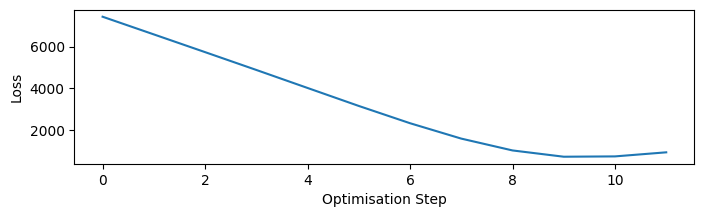

In [251]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)
gp.deactivate_robustness()

losses = []
n_steps = 12
lr = 0.4

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

frac = 0.92

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    loss = scoring_rule(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    #loss = weighted_loss1(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [252]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.03473491966724396

----Spatial Lengthscale, Magnitude-----
5.868826389312744 1.6822456121444702

----Temporal Lengthscale, Magnitude----
0.23053891956806183 1.6819685697555542


Sum Absolute Diff (pred - true) :  tensor(949.4432) 

Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  81.2104263305664
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  88.04625701904297
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  118.0550537109375
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  97.783447265625
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  98.14863586425781
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  92.70046997070312
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  98.42276000976562
Mean Absolute Difference (Data - No Outliers) :  98.4655456542968

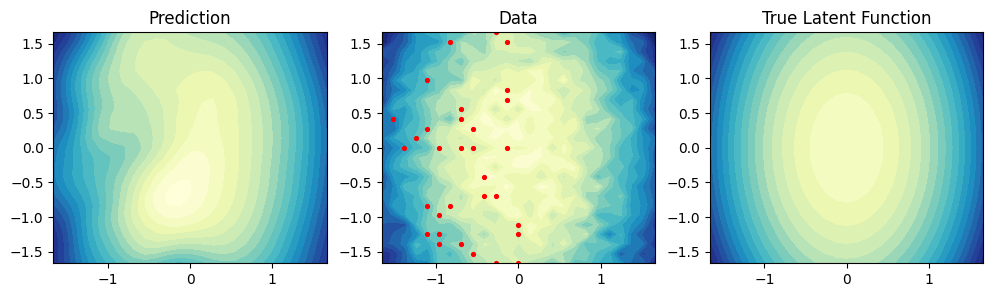

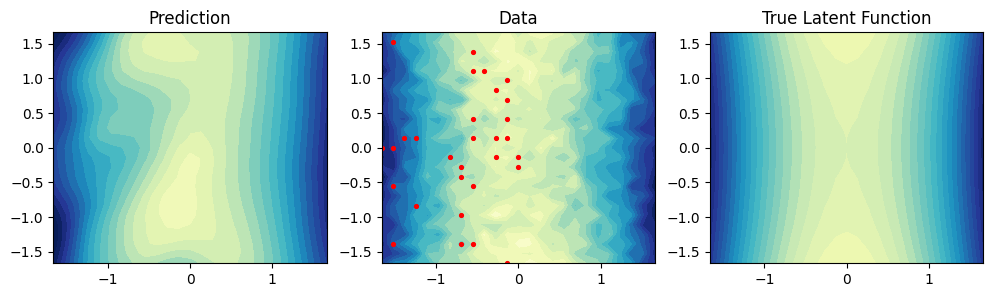

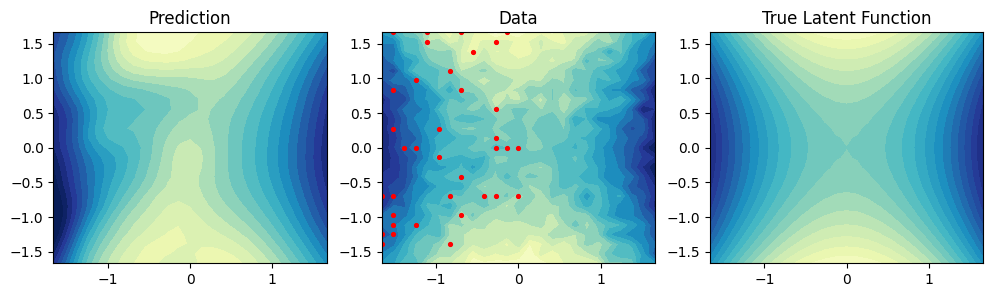

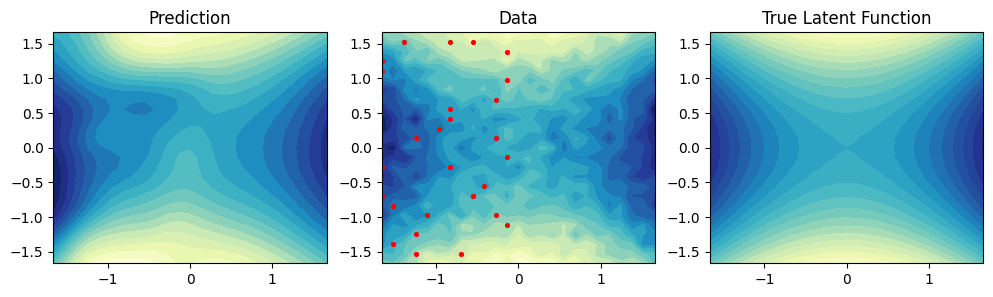

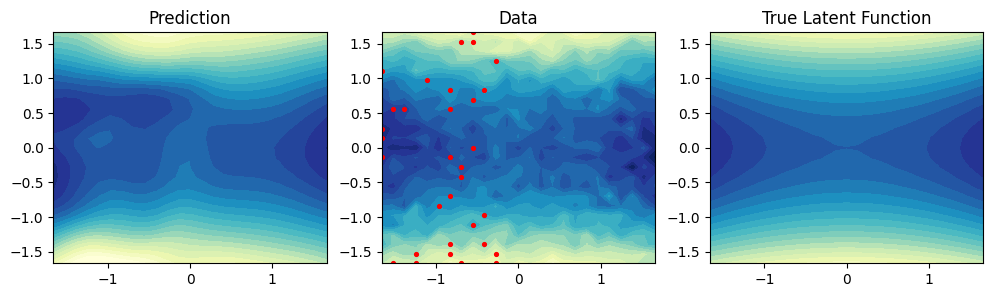

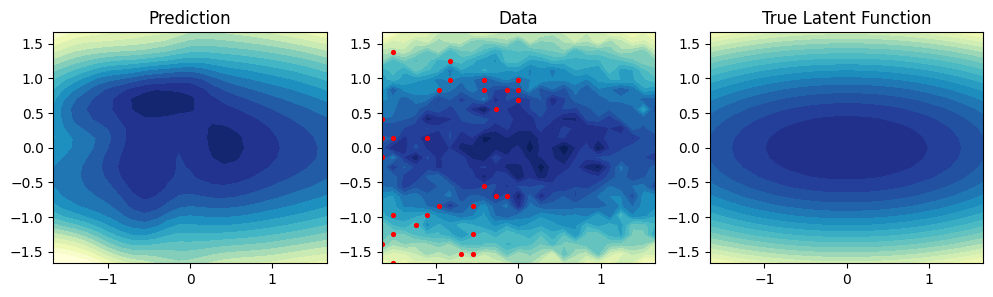

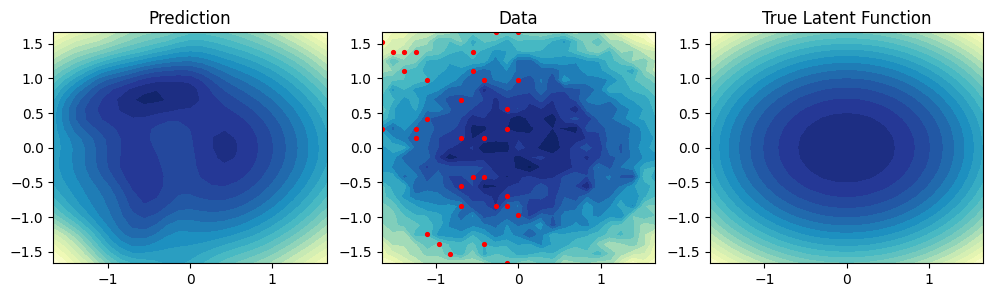

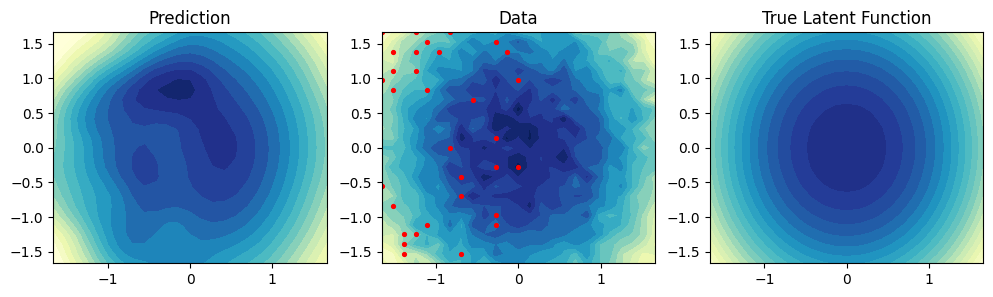

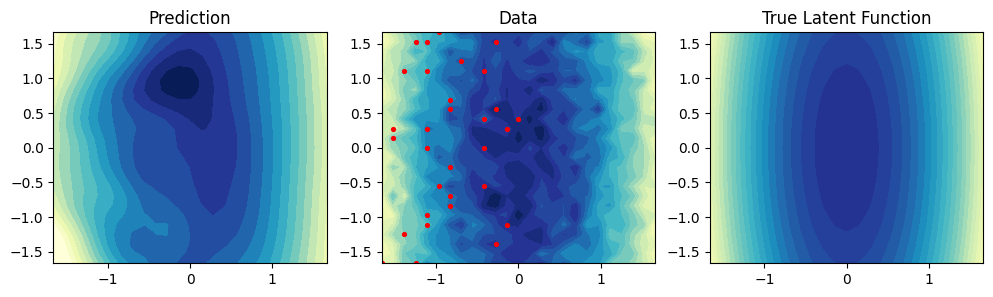

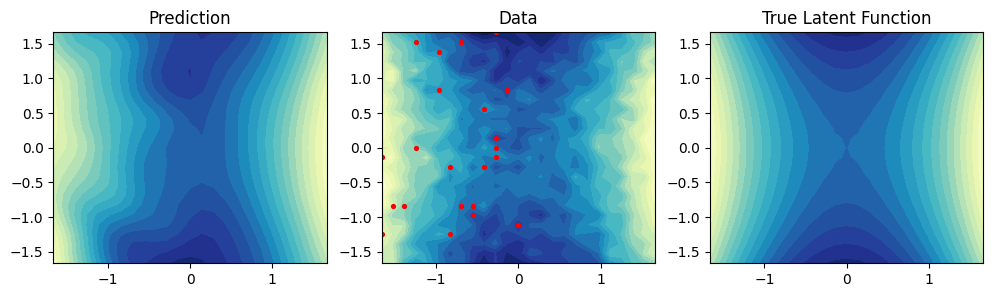

In [253]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print("Sum Absolute Diff (pred - true) : ", (tc.abs(preds_smooth - true_Ys.squeeze(-1))).sum(), "\n")

for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)

### ST-RCGP (adaptive c, spatial smoothing prior mean)

100%|██████████| 30/30 [00:33<00:00,  1.10s/it]


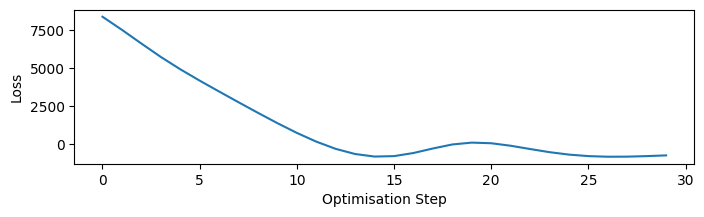

In [248]:
gp = SpatioTemporalRCGP(ts=ts, grid=grids[0], Ys=Ys, p=1)

gp.activate_robustness(func="local_constant") 
gp._K_w_lengthscale = 2.

gp.adaptive_c()

losses = []
n_steps = 30
lr = 0.3

optimizer = tc.optim.Adam(gp.parameters(), lr=lr)

for step in tqdm(range(n_steps)):
    _,(preds, covs, R, Ws), _ = gp.forward(smoothing=False)

    loss = scoring_rule(Ys=Ys_no_outliers, preds=preds, covs=covs, R=R, Ws=Ws)
    #loss = weighted_loss1(Ys=Ys, preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())

    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

In [249]:
print("---Likelihood Variance----")
print(gp.var_y.clone().detach().item())
print("\n----Spatial Lengthscale, Magnitude-----")
print(gp.spatial_lengthscale.clone().detach().item(), gp.spatial_magnitude.clone().detach().item())
print("\n----Temporal Lengthscale, Magnitude----")
print(gp.temporal_lengthscale.clone().detach().item(), gp.temporal_magnitude.clone().detach().item())

---Likelihood Variance----
0.05297566577792168

----Spatial Lengthscale, Magnitude-----
5.788687705993652 3.2718145847320557

----Temporal Lengthscale, Magnitude----
0.16514161229133606 3.2709386348724365


Sum Absolute Diff (pred - true) :  tensor(232.4019)
Mean Absolute Difference (Data - No Outliers) :  101.3565444946289
Mean Absolute Difference (Prediction) :  28.815656661987305
Mean Absolute Difference (Data - No Outliers) :  97.08243560791016
Mean Absolute Difference (Prediction) :  25.822059631347656
Mean Absolute Difference (Data - No Outliers) :  98.51832580566406
Mean Absolute Difference (Prediction) :  24.71916961669922
Mean Absolute Difference (Data - No Outliers) :  100.95301818847656
Mean Absolute Difference (Prediction) :  25.687602996826172
Mean Absolute Difference (Data - No Outliers) :  93.23451232910156
Mean Absolute Difference (Prediction) :  24.380128860473633
Mean Absolute Difference (Data - No Outliers) :  97.20365142822266
Mean Absolute Difference (Prediction) :  17.39136505126953
Mean Absolute Difference (Data - No Outliers) :  100.76924896240234
Mean Absolute Difference (Prediction) :  17.137372970581055
Mean Absolute Difference (Data - No Outliers) :  98.4655456

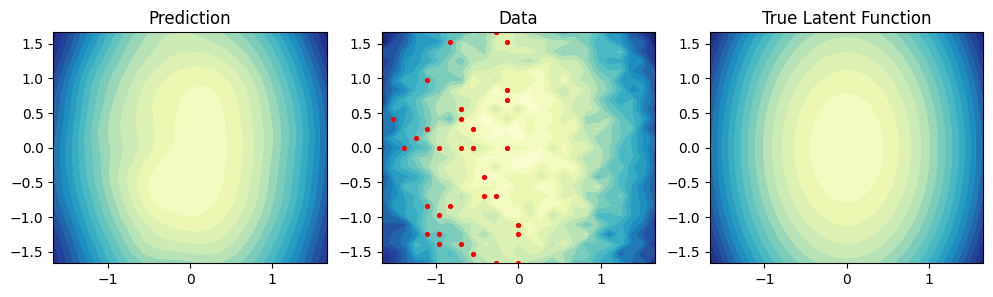

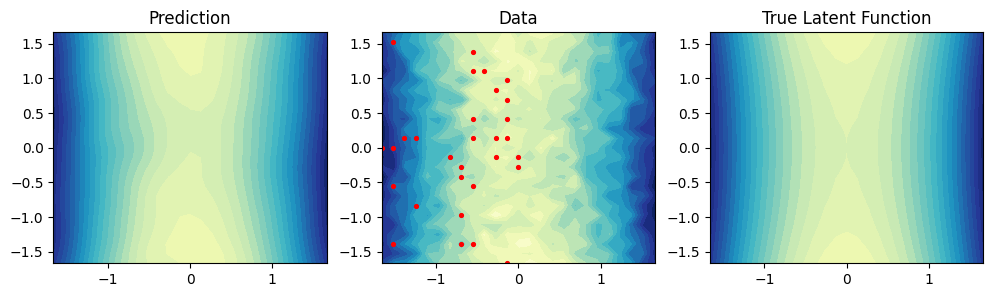

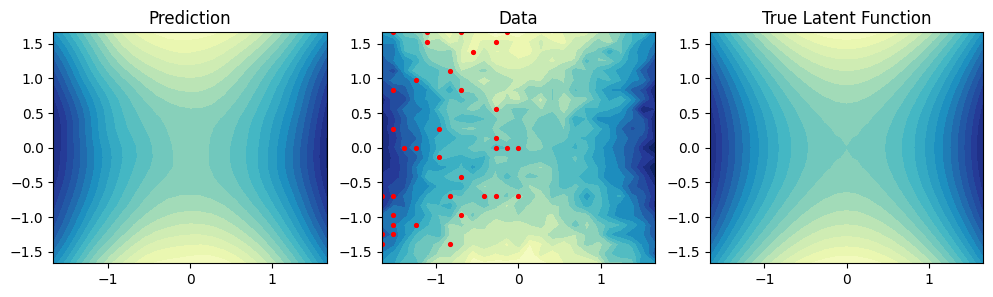

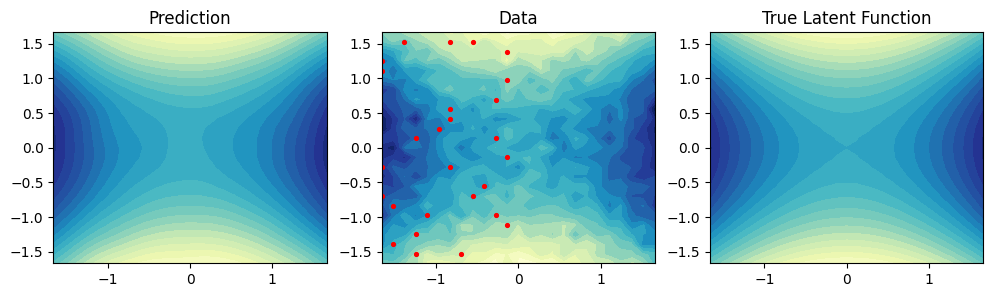

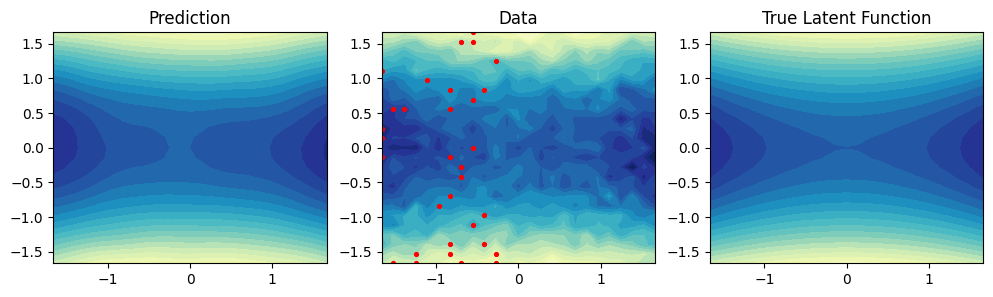

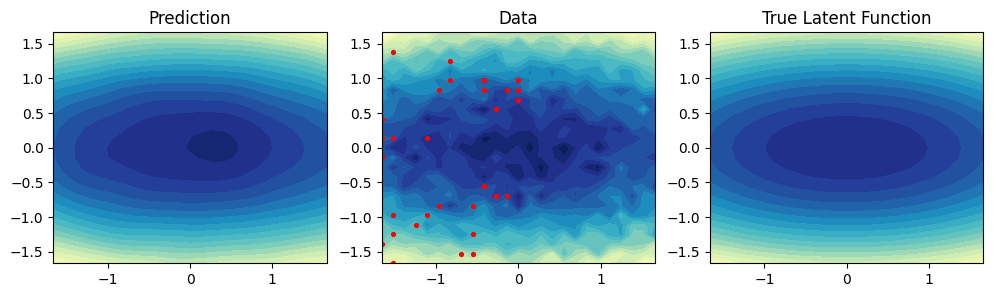

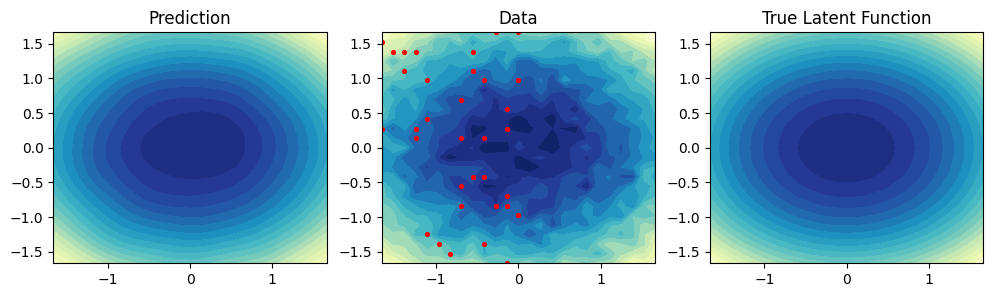

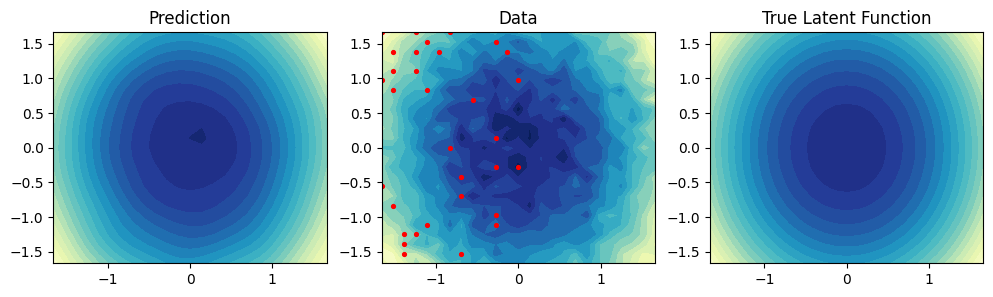

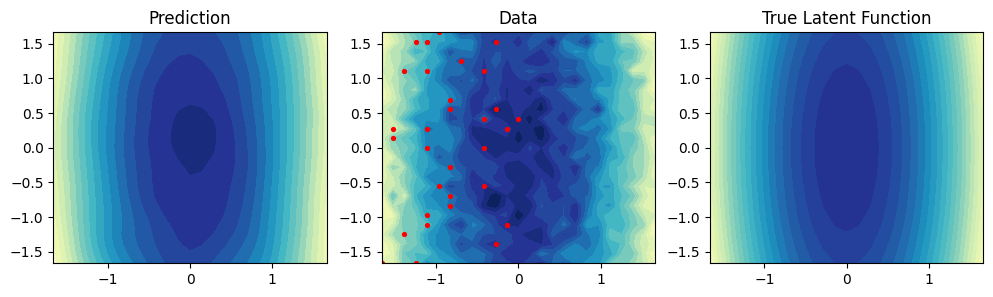

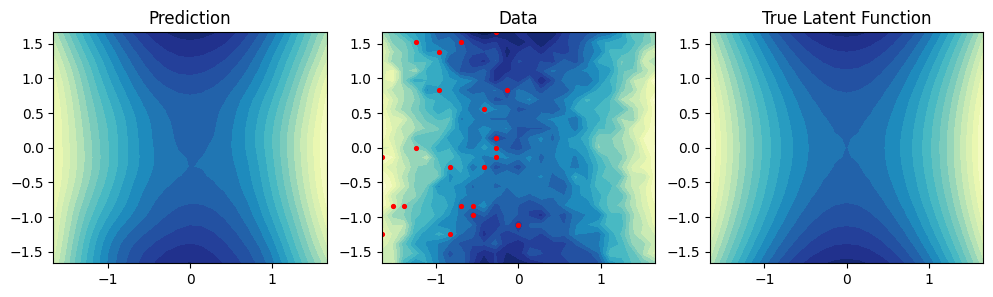

In [250]:
with tc.no_grad():
    (preds_smooth, stds_smooth, eff), (preds_filt, covs_filt, R, Ws_norm), (ms, Ps) = gp.forward(smoothing=True)

    print("Sum Absolute Diff (pred - true) : ", (tc.abs(preds_smooth - true_Ys.squeeze(-1))).sum())

for i in range(10):
    plot(idx=i, grid=grids[0], ts=ts, pred=preds_smooth, Ys=Ys, Ys_no_outliers=Ys_no_outliers, outliers_loc=outliers_loc, true_Ys=true_Ys, n_lon=n_lon, n_lat=n_lat)